Latex Definitions.

$$
\newcommand{\prox}{\operatorname{prox}}
\newcommand{\E}{\mathop{\mathbb{E}}} % expectation
\newcommand{\V}{\operatorname{Var}} % variance
\newcommand{\Cov}{\operatorname{Cov}}
\newcommand{\vect}{\operatorname{vec}}
\newcommand{\vech}{\operatorname{vech}}
\newcommand{\tr}{\operatorname{tr}}
\newcommand{\logdet}{\operatorname{logdet}}
\newcommand{\rank}{\mathrm{rank}}
\newcommand{\diag}{\mathrm{diag}}
\newcommand{\Abf}{{\mathbf A}}
\newcommand{\Bbf}{{\mathbf B}}
\newcommand{\Cbf}{{\mathbf C}}
\newcommand{\Dbf}{{\mathbf D}}
\newcommand{\Ebf}{{\mathbf E}}
\newcommand{\Fbf}{{\mathbf F}}
\newcommand{\Gbf}{{\mathbf G}}
\newcommand{\Hbf}{{\mathbf H}}
\newcommand{\Ibf}{{\mathbf I}}
\newcommand{\Jbf}{{\mathbf J}}
\newcommand{\Lbf}{{\mathbf L}}
\newcommand{\Kbf}{{\mathbf K}}
\newcommand{\Mbf}{{\mathbf M}}
\newcommand{\Obf}{{\mathbf O}}
\newcommand{\Pbf}{{\mathbf P}}
\newcommand{\Qbf}{{\mathbf Q}}
\newcommand{\Rbf}{{\mathbf R}}
\newcommand{\Sbf}{{\mathbf S}}
\newcommand{\Tbf}{{\mathbf T}}
\newcommand{\Ubf}{{\mathbf U}}
\newcommand{\Vbf}{{\mathbf V}}
\newcommand{\Wbf}{{\mathbf W}}
\newcommand{\Xbf}{{\mathbf X}}
\newcommand{\Ybf}{{\mathbf Y}}
\newcommand{\Zbf}{{\mathbf Z}}
\newcommand{\abf}{{\mathbf a}}
\newcommand{\bbf}{{\mathbf b}}
\newcommand{\cbf}{{\mathbf c}}
\newcommand{\dbf}{{\mathbf d}}
\newcommand{\ebf}{{\mathbf e}}
\newcommand{\fbf}{{\mathbf f}}
\newcommand{\gbf}{{\mathbf g}}
\newcommand{\lbf}{{\mathbf l}}
\newcommand{\nbf}{{\mathbf n}}
\newcommand{\pbf}{{\mathbf p}}
\newcommand{\qbf}{{\mathbf q}}
\newcommand{\rbf}{{\mathbf r}}
\newcommand{\tbf}{{\mathbf t}}
\newcommand{\ubf}{{\mathbf u}}
\newcommand{\vbf}{{\mathbf v}}
\newcommand{\wbf}{{\mathbf w}}
\newcommand{\xbf}{{\mathbf x}}
\newcommand{\ybf}{{\mathbf y}}
\newcommand{\zbf}{{\mathbf z}}
\newcommand{\alphabf}{\mathbf{\alpha}}
\newcommand{\betabf}{\mathbf{\beta}}
\newcommand{\deltabf}{\mathbf{\delta}}
\newcommand{\Deltabf}{\mathbf{\Delta}}
\newcommand{\etabf}{\mathbf{\eta}}
\newcommand{\epsilonbf}{\mathbf{\varepsilon}}
\newcommand{\gammabf}{\mathbf{\gamma}}
\newcommand{\mubf}{\mathbf{\mu}}
\newcommand{\nubf}{\mathbf{\nu}}
\newcommand{\pibf}{\mathbf{\pi}}
\newcommand{\phibf}{\mathbf{\phi}}
\newcommand{\psibf}{\mathbf{\psi}}
\newcommand{\sigmabf}{\mathbf{\sigma}}
\newcommand{\taubf}{\mathbf{\tau}}
\newcommand{\zetabf}{\mathbf{\zeta}}
\newcommand{\thetabf}{\mathbf{\theta}}
\newcommand{\lambdabf}{\mathbf{\lambda}}
\newcommand{\Gammabf}{\mathbf{\Gamma}}
\newcommand{\Phibf}{\mathbf{\Phi}}
\newcommand{\Psibf}{\mathbf{\Psi}}
\newcommand{\Sigmabf}{\mathbf{\Sigma}}
\newcommand{\Lambdabf}{\mathbf{\Lambda}}
\newcommand{\Omegabf}{\mathbf{\Omega}}
\newcommand{\Pibf}{\mathbf{\Pi}}
\newcommand{\Thetabf}{\mathbf{\Theta}}
$$

In [1]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: macOS (arm64-apple-darwin21.3.0)
  CPU: 10 × Apple M1 Pro
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, apple-m1)
  Threads: 1 on 8 virtual cores


In [2]:
using Pkg
Pkg.activate(joinpath(@__DIR__, ".."))

In [3]:
Pkg.instantiate()

In [4]:
# load packages
using BenchmarkTools, DataFrames, Distributions, DynamicHMC, DynamicHMC.Diagnostics, 
    LinearAlgebra, LogDensityProblems, MCMCChains, MCMCDiagnosticTools,
    Parameters, Profile, ProximalOperators,
    Random, Revise, Roots, SparseArrays, Statistics, RCall
import ProximalOperators: prox, prox!

# Projection to $\ell_1$ norm epigraph

We first implement the projection to the $\ell_1$ norm epigraph $\{(y, t): \|y\|_1 \le t\}$. To project a point $(x,s)$, the key computation is to find the root of 
$$
\phi(\lambda) = \|S_\lambda(x)\|_1 - \lambda - s,
$$
where $S$ is the sof-thresholding operator. This can be achieved by bisection or the sum-of-max algorithm (Algorithm 2 of <http://proceedings.mlr.press/v48/wangh16.pdf>). Both have linear complexity.

In [5]:
"""
    ϕ(x::Vector, λ)

Return the value `sum(abs, Sλ(x[1:end-1])) - λ - x[end]`.
"""
function ϕ(x::AbstractVector{T}, λ::T) where T <: Real
    out = zero(T)
    @inbounds for i in 1:(length(x) - 1)
        δi = abs(x[i]) - λ
        out += δi > 0 ? abs(δi) : zero(T)
    end
    out -= λ + x[end]
    out
end

ϕ

Now we can implement the projector to the $\ell_1$ norm epigraph
$$
\text{prox}_{\chi_{\mathcal{E}}}(x, s) = \text{proj}_{\mathcal{E}}(x) = \begin{cases}
(x, s) & \|x\|_1 \le s \\
(S_{\lambda^\star}(x), s + \lambda^\star) & \|x\|_1 > s
\end{cases},
$$
where $\lambda^\star$ is the root of $\phi(\lambda)$.

In [6]:
struct NormL1Epigraph end

is_convex(f::NormL1Epigraph) = true
is_set(f::NormL1Epigraph) = true

function prox!(
        y :: AbstractVector{T}, 
        f :: NormL1Epigraph, 
        x :: AbstractVector{T}, 
        γ :: T = T(1.0)
    ) where T <: Real
    if isinf(x[end]) || sum(abs, x) ≤ x[end] + abs(x[end])
        copyto!(y, x)
        return zero(T)
    end
    @views λ₀ = find_zero(λ -> ϕ(x, λ), (0, maximum(abs, x[1:end-1])), Bisection())
    for i in 1:(length(y) - 1)
        δi   = abs(x[i]) - λ₀
        y[i] = δi > 0 ? copysign(δi, x[i]) : zero(T) 
    end
    y[end] = x[end] + λ₀
    zero(T)
end

prox(f::NormL1Epigraph, x::AbstractVector{T}, γ::T = T(1.0)) where T<:Real = 
    prox!(similar(x), f, x, γ)

prox (generic function with 4 methods)

In [7]:
# test projection to affine set
A = ones(1, 3)
b = zeros(1)
g2 = IndAffine(A, b; iterative=false)
β = [1.5, -1.1, 0]
βprox = similar(β)
prox!(βprox, g2, β)

0.0

In [8]:
βprox

3-element Vector{Float64}:
  1.3666666666666667
 -1.2333333333333334
 -0.1333333333333334

Define the constrained lasso problem

In [9]:
struct CLassoProblem{T <: Real}
    y       :: Vector{T} # response
    X       :: Matrix{T} # design
    λ       :: T         # Moreau-Yosida envelope parameter
    eqcons  :: Tuple{Matrix{T}, Vector{T}} # equality constraints
    σ²prior :: Tuple{T, T} # IG(r, s) prior for σ²
    αprior  :: Tuple{T, T} # IG(r, s) prior for α
    res     :: Vector{T} # storage for residuals y-Xβ
    β       :: Vector{T}
    β_prox  :: Vector{T}
    βα      :: Vector{T}
    βα_prox :: Vector{T}
end

# constructor
function CLassoProblem(y::Vector{T}, X::Matrix{T}, λ::T, eqcons::Tuple{Matrix{T}, Vector{T}},
        σ²prior::Tuple{T, T}, αprior::Tuple{T, T}) where T <: Real
    p = size(X, 2)
    res = similar(y)
    β       = Vector{T}(undef, p)
    β_prox  = similar(β)
    βα      = Vector{T}(undef, p + 1)
    βα_prox = similar(βα)
    CLassoProblem{T}(y, X, λ, eqcons, σ²prior, αprior, res, β, β_prox, βα, βα_prox)
end

CLassoProblem

Essential ingredients for the HMC algorithm is the log-density and its gradient.

In [10]:
(problem::CLassoProblem)(θ) = LogDensityProblems.logdensity(problem, θ)

LogDensityProblems.capabilities(::Type{<:CLassoProblem}) =
    LogDensityProblems.LogDensityOrder{1}()

LogDensityProblems.dimension(problem::CLassoProblem) = size(problem.X, 2) + 2

function LogDensityProblems.logdensity(problem::CLassoProblem, θ)
    @unpack y, X, λ, eqcons, σ²prior, αprior, res, β, β_prox, βα, βα_prox = problem
    n, p = size(X)
    copyto!(β, 1, θ, 1, p)
    logα     = θ[p + 1]
    logσ²    = θ[p + 2]
    σ², α = exp(logσ²), exp(logα)
    A, b  = eqcons
    g2 = IndAffine(A, b; iterative=false)
    rσ², sσ² = σ²prior
    rα , sα  = αprior
    # log-likelihood + log(prior), with constant terms dropped
    mul!(res, X, β) # res stores Xβ now
    res  .= y .- res
    logl  = - (abs2(norm(res)) + 2rσ²) / (2σ²) - (n / 2 + sσ²) * logσ²
    logl += - rα / α - sα * logα
    # proximal mapping of g1
    copyto!(βα, β)
    βα[end] = α
    prox!(βα_prox, NormL1Epigraph(), βα)
    βα_prox .= βα .- βα_prox
    logl -= abs2(norm(βα_prox)) / (2λ)
    # proximal mapping of g2
    prox!(β_prox, g2, β)
    β_prox  .= β .- β_prox
    logl -= abs2(norm(β_prox)) / (2λ)
    logl
end

function LogDensityProblems.logdensity_and_gradient(problem::CLassoProblem{T}, θ) where T <: Real
    @unpack y, X, λ, eqcons, σ²prior, αprior, res, β, β_prox, βα, βα_prox = problem
    A, b  = eqcons
    g2    = IndAffine(A, b; iterative=false)
    rσ², sσ² = σ²prior
    rα , sα  = αprior    
    n, p     = size(X)
    copyto!(β, 1, θ, 1, p)
    logα     = θ[p + 1]
    logσ²    = θ[p + 2]
    α        = exp(logα)
    σ²       = exp(logσ²)
    invσ²    = inv(σ²)
    invλ     = inv(λ)
    # log-likelihood + log(prior), with constant terms dropped
    mul!(res, X, β) # res stores Xβ now
    res     .= y .- res
    qf       = (abs2(norm(res)) + 2rσ²) / (2σ²)
    logl     = - qf - (n / 2 + sσ²) * logσ² - rα / α - sα * logα 
    ∇ = fill(T(0), p+2)
    mul!(view(∇, 1:p), transpose(X), res)    
    ∇[1 : p] .*= invσ²            # ∇β
    ∇[p + 1] = rα / α - sα        # ∇logα
    ∇[p + 2] = qf - (n / 2 + sσ²) # ∇logσ²
    # proximal mapping of (β, α)
    copyto!(βα, β)
    βα[end]  = α
    prox!(βα_prox, NormL1Epigraph(), βα)
    βα_prox .= βα .- βα_prox
    logl    -= abs2(norm(βα_prox)) / (2λ)
    @views ∇[1:p] .-= invλ .* βα_prox[1:p]
    ∇[p+1]  -= invλ * α * βα_prox[p + 1]
    # proximal mapping of g2
    prox!(β_prox, g2, β)
    β_prox  .= β .- β_prox
    logl -= abs2(norm(β_prox)) / (2λ)
    @views ∇[1:p] .-= invλ .* β_prox
    logl, ∇
end

# Simulated microbiome example

In [11]:
using Random

In [12]:
# Data simulation borrowed from http://hua-zhou.github.io/teaching/biostatm280-2019spring/slides/20-juliaopt/juliaopt.html

Random.seed!(1001)
n, p = 1000, 10
X = rand(n, p)
# scale each row of X to sum to 1
lmul!(Diagonal(1 ./ vec(sum(X, dims=2))), X)
k = 1
β = [1 .* ones(k); -1 .* ones(k); zeros(p - 2*k)]
y = X * β + 0.1 * randn(n);

In [13]:
# signal to noise ratio
# https://statproofbook.github.io/D/snr.html
# https://statproofbook.github.io/P/snr-rsq.html
# https://www.pnas.org/doi/10.1073/pnas.1505545112
var(X * β) / 0.01

0.7178500185182708

In [15]:
# λ is Moreau-Yosida envelope approximation parameter
λ = 1e-5
# a flat IG(r, s) prior for σ²
σ²prior = (0.01, 0.01) 
# IG(r, s) prior for α, mean is r / (s - 1)
αprior  = (1.0, p+1.0) 
eqcons  = (ones(1, p), zeros(1))
clp = CLassoProblem(y, X, λ, eqcons, σ²prior, αprior);

In [16]:
# start β from LS solution 
β₀ = X \ y
# pick reasonable initial values for other parameters
α₀ = 2.0 
σ₀ = 1.0
θ = vcat(β₀, log(α₀), 2log(σ₀));

In [17]:
LogDensityProblems.logdensity_and_gradient(clp, θ);

In [18]:
@show sum(abs, β₀);

sum(abs, β₀) = 2.110973758382085


In [19]:
# timing
@time results = mcmc_with_warmup(Random.GLOBAL_RNG, clp, 10_000, reporter=ProgressMeterReport());

 13.694229 seconds (47.74 M allocations: 3.956 GiB, 3.64% gc time, 26.39% compilation time)


In [20]:
# diagnostics
summarize_tree_statistics(results.tree_statistics)

Hamiltonian Monte Carlo sample of length 10000
  acceptance rate mean: 0.92, 5/25/50/75/95%: 0.71 0.88 0.96 0.99 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 0%, 3 => 0%, 4 => 1%, 5 => 4%, 6 => 94%, 7 => 1%

In [21]:
results_matrix = transpose(results.posterior_matrix);

In [22]:
size(results.posterior_matrix)

(12, 10000)

In [23]:
# ESS for β
cov_matrix = cov(results_matrix[:, 1:p])
F = svd(cov_matrix)
v_strongest = F.V[:,1]
slowest = results_matrix[:, 1:p] * v_strongest;

In [24]:
chn_slowest = MCMCChains.Chains(slowest, ["βslowest"], thin = 1);

In [25]:
ess_slowest = ess_rhat(chn_slowest)

ESS
  parameters         ess      rhat 
      Symbol     Float64   Float64 

    βslowest   7044.0511    1.0001


In [26]:
chn = MCMCChains.Chains(
    results_matrix,
    ["β[" .* string.(1:size(X, 2)) .* "]"; "α"; "σ²"],
    thin = 1);

In [27]:
result_summary = DataFrame(summarize(chn));
result_quantile = DataFrame(quantile(chn));

In [28]:
df1 = DataFrame(truth = β, lower = result_quantile[1:length(β), 2], upper = result_quantile[1:length(β), 6]);

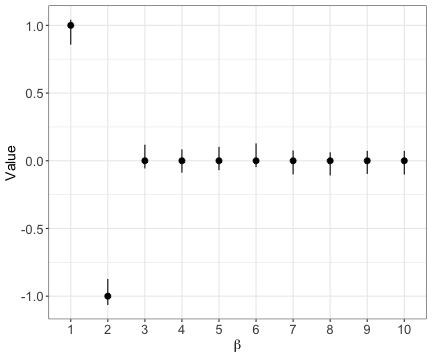

RObject{VecSxp}


In [29]:
@rput df1
R"""
library(ggplot2)
library(grid)
library(latex2exp)
firstx = 10 # Plot the firstx entries
df1$Variable <- factor(1:nrow(df1))
ggplot(df1) + geom_point(aes(x=lower, y=upper))
ggplot(df1[1:firstx, ], aes(Variable)) + 
  geom_linerange(aes(ymin = lower, ymax = upper)) + 
  geom_point(aes(x = Variable, y = truth), size = 2.5) + 
  labs(y = "Value", x = TeX(r'($\beta$)')) + 
  theme_bw() + 
  theme(axis.text=element_text(size=13), axis.title=element_text(size=14))
#ggsave("../plots/constrained-lasso-CI.eps", width = 4, height = 4, dpi = 300)
"""

## Plot the histogram of $\sum\betabf_i$

In [30]:
function Aβminusb(A, β, b)
    n   = size(β, 1)
    res = zeros(n, length(b))
    for i in 1:n
        res[i, :] = A * β[i, :] - b
    end
    res
end

Aβminusb (generic function with 1 method)

In [31]:
res = Aβminusb(ones(1, p), results_matrix[:, 1:p], zeros(1));

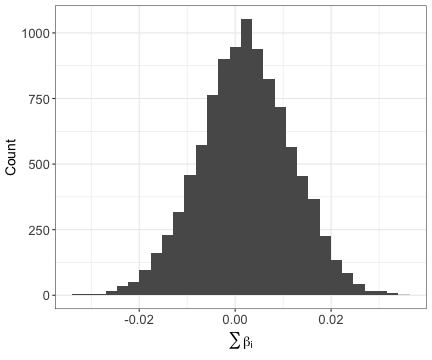

RObject{VecSxp}


In [32]:
@rput res
R"""
library(ggplot2)
df2 = data.frame(res = res)
ggplot(df2, aes(res), dpi = 300) + geom_histogram() + theme_bw() + 
  labs(x = TeX(r'($\sum\beta_i$)'), y = "Count") + 
  theme(axis.text=element_text(size=13), axis.title=element_text(size=14))
#ggsave("../plots/constrained-lasso-histogram.eps", width = 4, height = 4, dpi = 300)
"""

# Estimate coverage probability

Repeat the above experiment 1000 times to estimate the coverage probability of ProxMCMC 95% credible intervals.

In [33]:
function calculate_coverage(res_mx, truth)
    p = length(truth)
    covers = zeros(p)
    chn = MCMCChains.Chains(results_matrix[:, 1:p], ["β[" .* string.(1:p) .* "]";], thin = 10)
    qtn = quantile(chn)
    lower = qtn[:, 2]
    upper = qtn[:, 6]
    for i in 1:p
       covers[i] =  (lower[i] ≤ truth[i]) & (truth[i] ≤ upper[i])
    end
    return(covers)
end

calculate_coverage (generic function with 1 method)

In [34]:
n, p = 1000, 10
k = 1
β = [1 .* ones(k); -1 .* ones(k); zeros(p - 2*k)]
λ = 1e-5
σ²prior = (0.01, 0.01) 
αprior  = (1.0, p+1.0) 
eqcons  = (ones(1, p), zeros(1))

([1.0 1.0 … 1.0 1.0], [0.0])

In [ ]:
# takes 2-3 hours
nreps = 1000
covers_all = zeros(nreps, p)
for i in 1:nreps
    Random.seed!(1000+i)
    X = rand(n, p)
    # scale each row of X sum to 1
    lmul!(Diagonal(1 ./ vec(sum(X, dims=2))), X)
    y = X * β + 0.1 * randn(n);
    clp = CLassoProblem(y, X, λ, eqcons, σ²prior, αprior);
    # start β from LS solution 
    β₀ = X \ y
    # assign reasonable initial values to α₀ and σ₀
    α₀ = 2.0
    σ₀ = 1.0
    θ = vcat(β₀, log(α₀), 2log(σ₀))
    results = mcmc_with_warmup(Random.GLOBAL_RNG, clp, 10_000, reporter=NoProgressReport());
    results_matrix = transpose(results.posterior_matrix)   
    covers_all[i, :] = calculate_coverage(results_matrix, β)
end

In [50]:
coverage = sum(covers_all, dims = 1) / size(covers_all, 1)

1×10 Matrix{Float64}:
 0.941  0.947  0.972  0.965  0.963  0.968  0.964  0.969  0.976  0.961

In [53]:
@rput coverage
R"""
library(magrittr)
library(dplyr)
library(ggplot2)
dcoverage <- data.frame(Beta = 1:10, CP = as.vector(coverage))
ggplot(dcoverage) + 
  geom_point(aes(x = factor(Beta), y = CP)) + 
  geom_abline(intercept = 0.95, slope = 0, color = "red") + 
  labs(x = TeX(r'($\beta$)'), y = "Coverage Probability") +
  ylim(c(0.6, 1)) + theme_bw() + 
  theme(axis.text=element_text(size=13), axis.title=element_text(size=14))
#ggsave("../plots/constrained-lasso-coverage-prob.eps", width = 4, height = 4, dpi = 300)
"""

RObject{StrSxp}
[1] "../plots/constrained-lasso-coverage-prob.eps"
